# **YOGA POSE CLASSIFICATION USING EFFICIENTNET**

BY

        Anand K S [AM.EN.U4CSE19106]
        Bharath Prathap Nair [AM.EN.U4CSE19113]
        Rahan Manoj [AM.EN.U4CSE19144]

This notebook contains the code used to generate various efficient net architectures for yoga pose classification.

The dataset used in this notebook is taken from [Kaggle](www.kaggle.com/shrutisaxena/yoga-pose-image-classification-dataset). The creator of the dataset is Shruthi Saxena. The dataset comprises of 107 classes/yoga-poses and 5991 images.


**IMPORTING LIBRARIES**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from tqdm import tqdm                                
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# **LOADING THE DATASET**

In [ ]:
from google.colab import drive  
drive._mount('/content/drive') 

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Yoga_image/augged'
labels = os.listdir(data_dir)
for i in labels:
  l = os.listdir(data_dir+'/'+i)
  print(i, len(l))


hanumanasana 70
halasana 132
ustrasana 174
dwi pada viparita dandasana 110
janu sirsasana 96
bhujangasana 146
mayurasana 102
dandasana 120
simhasana 98
bitilasana 174
ananda balasana 118
gomukhasana 144
makarasana 114
salamba sirsasana 120
chakravakasana 140
virabhadrasana iii 122
parsva bakasana 112
ganda bherundasana 78
supta baddha konasana 142
anjaneyasana 128
parivrtta parsvakonasana 80
urdhva dhanurasana 136
eka pada koundinyanasana ii 116
eka pada koundinyanasana i 102
utthita trikonasana 138
durvasasana 78
upavistha konasana 120
viparita karani 138
virabhadrasana ii 111
salamba bhujangasana 110
yoganidrasana 92
bharadvajasana i 108
adho mukha svanasana 137
eka pada rajakapotasana 88
sukhasana 100
matsyasana 114
vasisthasana 148
astavakrasana 144
paripurna navasana 136
marichyasana i 98
agnistambhasana 66
virabhadrasana i 109
tulasana 62
kurmasana 80
marichyasana iii 66
marjaryasana 92
camatkarasana 108
adho mukha vriksasana 118
tolasana 120
salamba sarvangasana 134
parivrtta ja

# **DATA AUGMENTATION**

The number of images in the dataset was increased with the help of various data augmentation techniques. The data augmentation techniques used here are: 

1.   horizontal flip [fliph]
2.   adding noise
3.   rotation by 30 degree
4.   applying blur
5.   Translation [shifting the pixels of the image by specific amounts in x and y directions]

This was done with the help of the [image augmentor](https://github.com/codebox/image_augmentor) script

In [ ]:
for i in os.listdir('data_dir'):
  ! python main.py 'data_dir/{i}' fliph,noise_0.01,rot_30,blur_1.5,trans_20_10

In [ ]:
num_classes=len(labels)
num_classes

107

In the cell below, we load the images from the path data_dir. The images loaded are subjected to various transformations.

They are resized to size 256 * 256 and then randomly crops into size 224 * 224 inorder to match with the input size of image in efficientnet architectures. They are converted to tensors.The image pixels are also normalised inorder to bring them within the range [-1,1]

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), 
                                      transforms.RandomCrop(224),
                                     transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

In [ ]:
dataset.class_to_idx                                          # Shows index of each label for prediction purposes

{'adho mukha svanasana': 0,
 'adho mukha vriksasana': 1,
 'agnistambhasana': 2,
 'ananda balasana': 3,
 'anantasana': 4,
 'anjaneyasana': 5,
 'ardha bhekasana': 6,
 'ardha chandrasana': 7,
 'ardha matsyendrasana': 8,
 'ardha pincha mayurasana': 9,
 'ardha uttanasana': 10,
 'ashtanga namaskara': 11,
 'astavakrasana': 12,
 'baddha konasana': 13,
 'bakasana': 14,
 'balasana': 15,
 'bhairavasana': 16,
 'bharadvajasana i': 17,
 'bhekasana': 18,
 'bhujangasana': 19,
 'bhujapidasana': 20,
 'bitilasana': 21,
 'camatkarasana': 22,
 'chakravakasana': 23,
 'chaturanga dandasana': 24,
 'dandasana': 25,
 'dhanurasana': 26,
 'durvasasana': 27,
 'dwi pada viparita dandasana': 28,
 'eka pada koundinyanasana i': 29,
 'eka pada koundinyanasana ii': 30,
 'eka pada rajakapotasana': 31,
 'eka pada rajakapotasana ii': 32,
 'ganda bherundasana': 33,
 'garbha pindasana': 34,
 'garudasana': 35,
 'gomukhasana': 36,
 'halasana': 37,
 'hanumanasana': 38,
 'janu sirsasana': 39,
 'kapotasana': 40,
 'krounchasana': 

In [ ]:
targets = dataset.targets
len(targets) # After augmentation, the size of the dataset has increased as can be seen from its output. [11899]

11901

# **TRAIN - TEST SPLIT**

20% of the data is used for testing, while the remaining 80% is used for training. A stratified split was done so that the number of classes in training and test sets are split uniformly.

In [ ]:
from sklearn.model_selection import train_test_split
train_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.20,shuffle=True,stratify=targets) #train_idx, test_idx gives the indexes of the data in each split

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_idx)    # Based on the indexes we get after splitting in the above sets, we load the corresponding data 
testloader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=test_idx)      # into trainloader and testloader.

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
92


# **EFFICIENT NET**

In [ ]:
pip install efficientnet_pytorch   #Installing efficientnet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=46fa01582957bfa75975655190e7ed0a246eab2386853b98c3f324cf605853c5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
effNet = EfficientNet.from_pretrained('efficientnet-b0')   #Intialising efficientnet-b0.

#Based on requirement we can load different versions of efficientnet such as 'efficientnet-b1' ,'efficientnet-b2' etc, by changing the first parameter of line-2. 


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
effNet._fc

Linear(in_features=1280, out_features=1000, bias=True)

Creating a class for efficientnet. 

We can add more fully connected components to the existing architecture by adding the layers into the nn.Sequential() parameters.
Note that if we are using NLLLoss we need to have a logsoftmax function as the final activation function.

Also since we have 107 classes, it is imperative to add a layer with output dimension = 107 as we are predicting for 107 classes here. 

In [ ]:
import torch.nn as nn

class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        self.model =EfficientNet.from_pretrained('efficientnet-b0')       # Give variant as per requirement
        
        self.model._fc = nn.Sequential(
            nn.Linear(self.model._fc.in_features, 107),
            nn.LogSoftmax()                                               # Required if training with NLLLoss
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [ ]:
effNet = EfficientNet_b0()   # Initialsing an object of the class.

Loaded pretrained weights for efficientnet-b0


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
effNet = effNet.to('cuda')    # Load the model to GPU.

In [ ]:
optimizer = optim.Adadelta(effNet.parameters())     # Defining the optimiser.
loss_func = nn.NLLLoss()                            # Defining the loss function
                                                    # Vary optimiser and loss function as per requirement while training.

In [ ]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(10):   # Run for loop for number of times. The number of times is the epochs
    train_correct = 0
    total1 = 0
    running_loss = 0
    with tqdm(trainloader, unit="batch") as tepoch:
        for images, labels in tepoch:                               # Training the dataset
            tepoch.set_description(f"Training : Epoch {epoch+1}")
            images, labels = images.cuda(), labels.cuda()
            labels = labels.long()
            optimizer.zero_grad()
            outputs = effNet(images) 
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total1 += labels.size(0)

            if torch.cuda.is_available():
                train_correct += (predicted.cpu() == labels.cpu()).sum().item()
                traincorrect = (predicted.cpu() == labels.cpu()).sum().item()
            else:
                train_correct += (predicted == labels).sum().item()
                traincorrect = (predicted == labels).sum().item()
            tepoch.set_postfix(loss=loss.item(), accuracy=100* (traincorrect/32.0))

    train_accuracy = 100 * train_correct / total1
    train_loss = running_loss/len(trainloader)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)


    test_loss = 0
    correct = 0
    total = 0
    pred = []
    test = []
    with tqdm(testloader, unit="batch") as tstepoch:      
        for images, labels in tstepoch:                                       # Testing 
            tstepoch.set_description(f"Testing : Epoch {epoch+1}")
            images, labels = images.cuda(), labels.cuda()
            labels = labels.long() 
            outputs = effNet(images)
            loss_t = loss_func(outputs, labels)
            test_loss += loss_t.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum().item()
                tstcorrect = (predicted.cpu() == labels.cpu()).sum().item()
            else:
                correct += (predicted == labels).sum().item()
                tstcorrect = (predicted == labels).sum().item()
            tstepoch.set_postfix(loss=loss_t.item(), accuracy=100*(tstcorrect/32.0))
 
    test_loss=test_loss/len(testloader)
    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    test_losses.append(test_loss)
    print('\nEpoch: {} - loss: {} - accuracy: {} - val_Loss: {} - val_accuracy: {}\n'.format(epoch+1, train_loss, train_accuracy, test_loss, accuracy))

Testing : Epoch 1: 100%|██████████| 75/75 [00:35<00:00,  2.10batch/s, accuracy=15.6, loss=1.59]



Epoch: 1 - loss: 2.4127414478551623 - accuracy: 38.00819413803971 - val_Loss: 1.6326942189534506 - val_accuracy: 52.18487394957983



Testing : Epoch 2: 100%|██████████| 75/75 [00:35<00:00,  2.13batch/s, accuracy=18.8, loss=0.829]



Epoch: 2 - loss: 1.131409535472025 - accuracy: 66.45656056308435 - val_Loss: 1.3115459537506104 - val_accuracy: 61.76470588235294



Testing : Epoch 3: 100%|██████████| 75/75 [00:35<00:00,  2.13batch/s, accuracy=28.1, loss=0.892]



Epoch: 3 - loss: 0.7290554819191062 - accuracy: 77.51864691669293 - val_Loss: 1.1764650734265645 - val_accuracy: 65.84033613445378



Testing : Epoch 4: 100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, accuracy=25, loss=0.655]



Epoch: 4 - loss: 0.5267601309706701 - accuracy: 83.2125223237735 - val_Loss: 1.1505393354098001 - val_accuracy: 67.22689075630252



Testing : Epoch 5: 100%|██████████| 75/75 [00:35<00:00,  2.10batch/s, accuracy=31.2, loss=0.627]



Epoch: 5 - loss: 0.37927360537668203 - accuracy: 87.69828763525581 - val_Loss: 1.1091577172279359 - val_accuracy: 69.6218487394958



Testing : Epoch 6: 100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, accuracy=25, loss=0.938]



Epoch: 6 - loss: 0.30670061686244987 - accuracy: 90.3456245403929 - val_Loss: 1.1562493872642516 - val_accuracy: 70.04201680672269



Testing : Epoch 7: 100%|██████████| 75/75 [00:36<00:00,  2.08batch/s, accuracy=31.2, loss=0.62]



Epoch: 7 - loss: 0.23697995815751136 - accuracy: 92.59375984872361 - val_Loss: 1.1488020857175192 - val_accuracy: 71.26050420168067



Testing : Epoch 8: 100%|██████████| 75/75 [00:36<00:00,  2.08batch/s, accuracy=28.1, loss=0.594]



Epoch: 8 - loss: 0.20348175364427717 - accuracy: 93.46570017859018 - val_Loss: 1.0932649596532187 - val_accuracy: 72.6470588235294



Testing : Epoch 9: 100%|██████████| 75/75 [00:35<00:00,  2.11batch/s, accuracy=34.4, loss=0.224]



Epoch: 9 - loss: 0.17472259305892573 - accuracy: 94.07500787897888 - val_Loss: 1.1146850293874742 - val_accuracy: 72.52100840336135



Testing : Epoch 10: 100%|██████████| 75/75 [00:36<00:00,  2.05batch/s, accuracy=28.1, loss=0.559]


Epoch: 10 - loss: 0.14002656460358393 - accuracy: 95.31463389011451 - val_Loss: 1.1904998882611593 - val_accuracy: 72.26890756302521



*Please note that the information above is not of the best model, the best model was saved when obtained and loaded below for evaluation purposes.*

In [ ]:
torch.save(effNet,'model-77.94-ADADELTA-NNLoss-aug')    # This is the cell wherein we saved the best model with 77.94% accuracy.

LOADING THE BEST MODEL FOR EVALUATION

In [ ]:
model = torch.load('/content/drive/MyDrive/model-77.94-ADADELTA-NNLoss-aug')       # Loading the model

Predcting on test data using saved model.

In [ ]:
pred = []
test = []
for images, labels in tqdm(testloader):
        images, labels = images.cuda(), labels.cuda()
        test.extend(labels)
        labels = labels.long() 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.extend(predicted)

100%|██████████| 75/75 [19:53<00:00, 15.92s/it]


Converting tensors to numpy to genrate classification reports

In [ ]:
predicted = []
tester = []
for i in pred:
    predicted.append(i.cpu().detach().numpy())
for i in test:
    tester.append(i.cpu().detach().numpy())
np_pred = np.array(predicted)
np_test = np.array(tester)

**CONFUSION MATRIX**

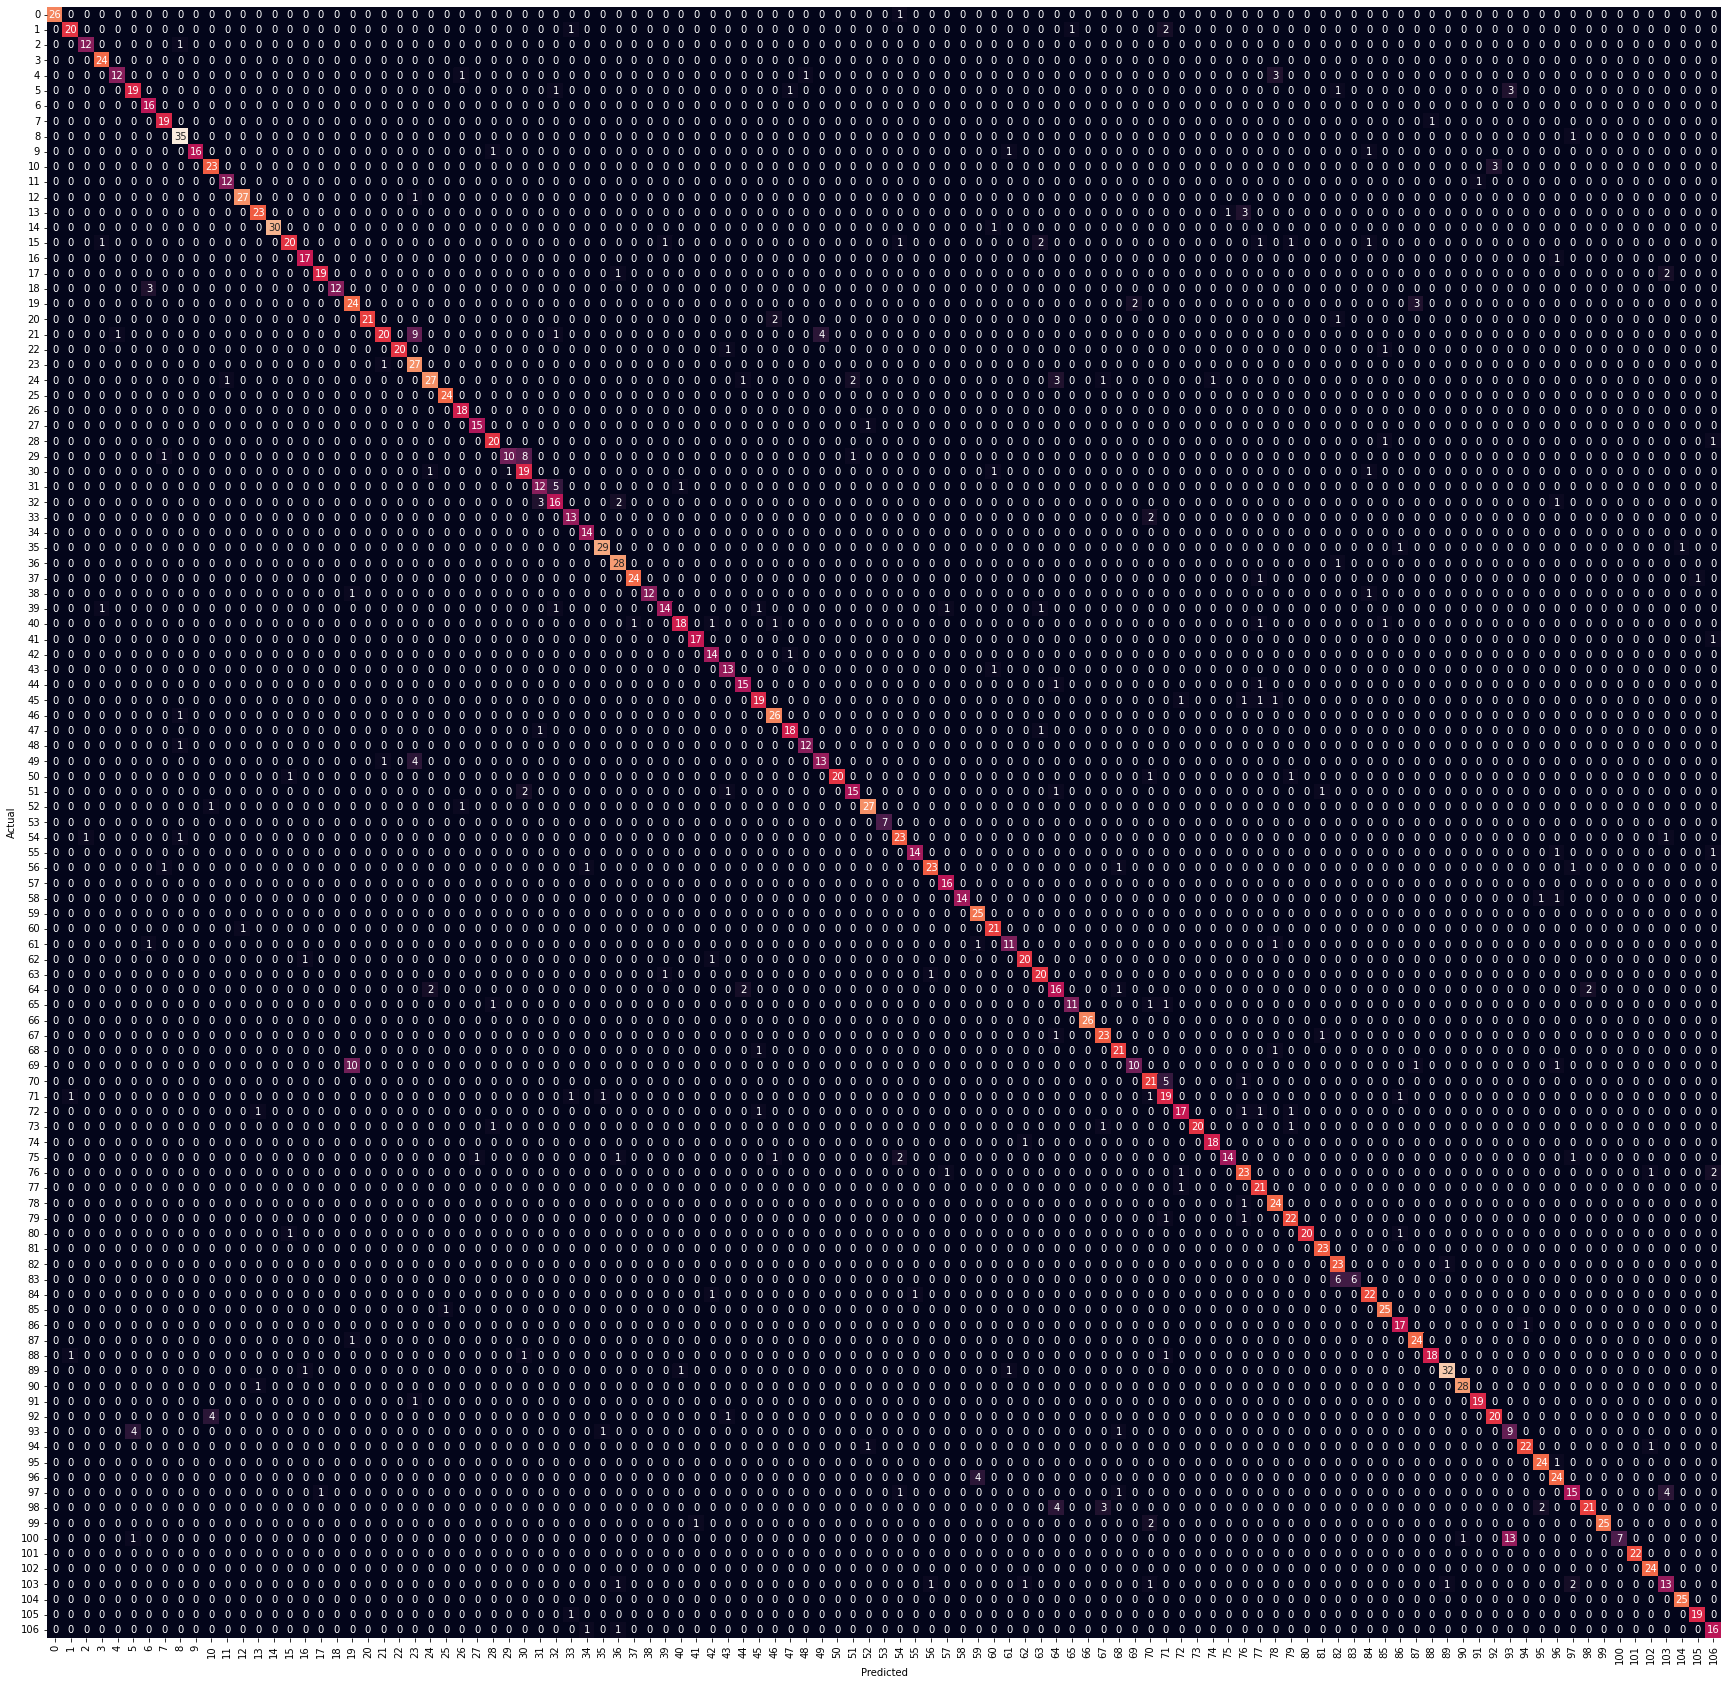

In [ ]:
import seaborn as sns
cm = confusion_matrix(np_test, np_pred)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,30))
sns.heatmap(df_cm, annot = True, fmt='d', cbar=False)

In [ ]:
classes = dataset.class_to_idx
  
new_dict = dict([(value, key) for key, value in classes.items()])
new_dict

{0: 'adho mukha svanasana',
 1: 'adho mukha vriksasana',
 2: 'agnistambhasana',
 3: 'ananda balasana',
 4: 'anantasana',
 5: 'anjaneyasana',
 6: 'ardha bhekasana',
 7: 'ardha chandrasana',
 8: 'ardha matsyendrasana',
 9: 'ardha pincha mayurasana',
 10: 'ardha uttanasana',
 11: 'ashtanga namaskara',
 12: 'astavakrasana',
 13: 'baddha konasana',
 14: 'bakasana',
 15: 'balasana',
 16: 'bhairavasana',
 17: 'bharadvajasana i',
 18: 'bhekasana',
 19: 'bhujangasana',
 20: 'bhujapidasana',
 21: 'bitilasana',
 22: 'camatkarasana',
 23: 'chakravakasana',
 24: 'chaturanga dandasana',
 25: 'dandasana',
 26: 'dhanurasana',
 27: 'durvasasana',
 28: 'dwi pada viparita dandasana',
 29: 'eka pada koundinyanasana i',
 30: 'eka pada koundinyanasana ii',
 31: 'eka pada rajakapotasana',
 32: 'eka pada rajakapotasana ii',
 33: 'ganda bherundasana',
 34: 'garbha pindasana',
 35: 'garudasana',
 36: 'gomukhasana',
 37: 'halasana',
 38: 'hanumanasana',
 39: 'janu sirsasana',
 40: 'kapotasana',
 41: 'krounchasan

**CLASSIFICATION REPORT**

In [ ]:
print(classification_report(np_test,np_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89        27
           1       0.81      0.71      0.76        24
           2       0.47      0.69      0.56        13
           3       0.77      0.96      0.85        24
           4       1.00      0.76      0.87        17
           5       0.64      0.72      0.68        25
           6       0.70      0.88      0.78        16
           7       1.00      0.90      0.95        20
           8       0.87      0.92      0.89        36
           9       0.83      0.79      0.81        19
          10       0.58      0.69      0.63        26
          11       0.89      0.62      0.73        13
          12       0.82      1.00      0.90        28
          13       0.75      0.67      0.71        27
          14       0.71      0.77      0.74        31
          15       1.00      0.82      0.90        28
          16       0.80      0.67      0.73        18
          17       0.65    

In [ ]:
cl = classification_report(np_test,np_pred, output_dict=True)
df = pd.DataFrame(cl).transpose()
df = df.iloc[:-3,]
df.index = dataset.classes
df

,precision,recall,f1-score,support
adho mukha svanasana,1.000000,0.962963,0.981132,27.0
adho mukha vriksasana,0.909091,0.833333,0.869565,24.0
agnistambhasana,0.923077,0.923077,0.923077,13.0
ananda balasana,0.923077,1.000000,0.960000,24.0
anantasana,0.923077,0.705882,0.800000,17.0
...,...,...,...,...
virabhadrasana iii,0.923077,1.000000,0.960000,24.0
virasana,0.650000,0.650000,0.650000,20.0
vriksasana,0.961538,1.000000,0.980392,25.0
vrischikasana,0.950000,0.950000,0.950000,20.0


In [ ]:
df.sort_values(by='f1-score', ascending=False)[:10].iloc[:,2].index

Index(['padangusthasana', 'virabhadrasana ii', 'prasarita padottanasana',
       'bakasana', 'adho mukha svanasana', 'vriksasana', 'dandasana',
       'utkatasana', 'astavakrasana', 'ananda balasana'],
      dtype='object')

# **PLOTTING TRAIN VS TEST ACCURACY**

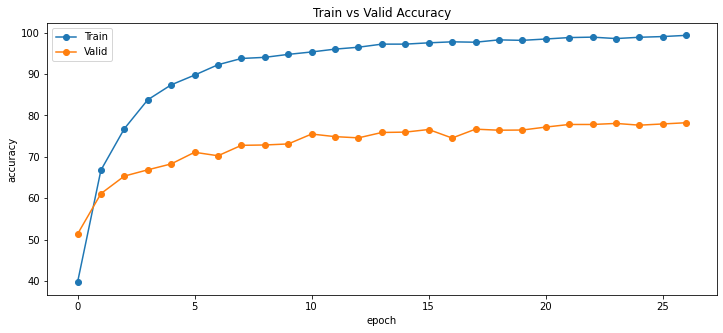

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.plot(train_acc,'-o')
plt.plot(test_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

**PLOTTING F1 SCORE FOR TOP - 10 and BOTTOM-10 CLASSES ON THE BASIS OF F1-SCORE:**

In [ ]:
cl = classification_report(np_test,np_pred, output_dict=True)
df = pd.DataFrame(cl).transpose()
df = df.iloc[:-3,]
df.index = dataset.classes
df

,precision,recall,f1-score,support
adho mukha svanasana,1.000000,0.962963,0.981132,27.0
adho mukha vriksasana,0.909091,0.833333,0.869565,24.0
agnistambhasana,0.923077,0.923077,0.923077,13.0
ananda balasana,0.923077,1.000000,0.960000,24.0
anantasana,0.923077,0.705882,0.800000,17.0
...,...,...,...,...
virabhadrasana iii,0.923077,1.000000,0.960000,24.0
virasana,0.650000,0.650000,0.650000,20.0
vriksasana,0.961538,1.000000,0.980392,25.0
vrischikasana,0.950000,0.950000,0.950000,20.0


In [ ]:
aa = df.sort_values(by='f1-score', ascending=False)[:10]
bb = df.sort_values(by='f1-score', ascending=True)[:10]
cc = pd.concat([aa,bb])
cc = cc.sort_values(by='f1-score', ascending=True)[:20]
cc

,precision,recall,f1-score,support
utthita ashwa sanchalanasana,0.360000,0.600000,0.450000,15.0
virabhadrasana i,1.000000,0.318182,0.482759,22.0
salamba bhujangasana,0.833333,0.454545,0.588235,22.0
eka pada koundinyanasana i,0.909091,0.500000,0.645161,20.0
virasana,0.650000,0.650000,0.650000,20.0
phalakasana,0.615385,0.695652,0.653061,23.0
tulasana,1.000000,0.500000,0.666667,12.0
eka pada rajakapotasana ii,0.666667,0.727273,0.695652,22.0
bitilasana,0.909091,0.571429,0.701754,35.0
eka pada rajakapotasana,0.750000,0.666667,0.705882,18.0


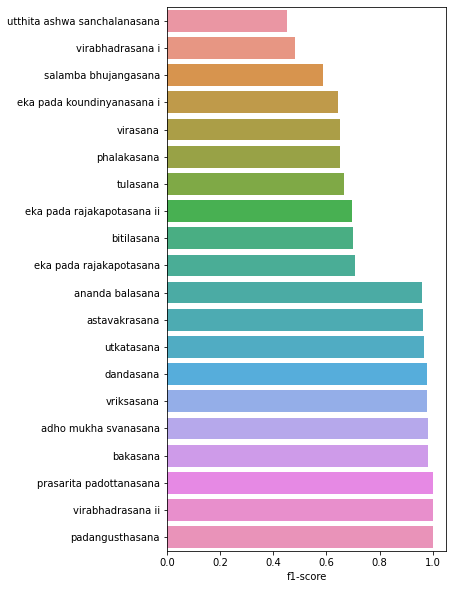

In [ ]:
fig = plt.figure(figsize=(5,10))
sns.barplot(y = cc.index, x=cc['f1-score'])

In [ ]:
fig.savefig("F1.pdf")

**TESTING ON RANDOM IMAGE**

In [ ]:
img = Image.open('/content/Vrikshasana.jpg')

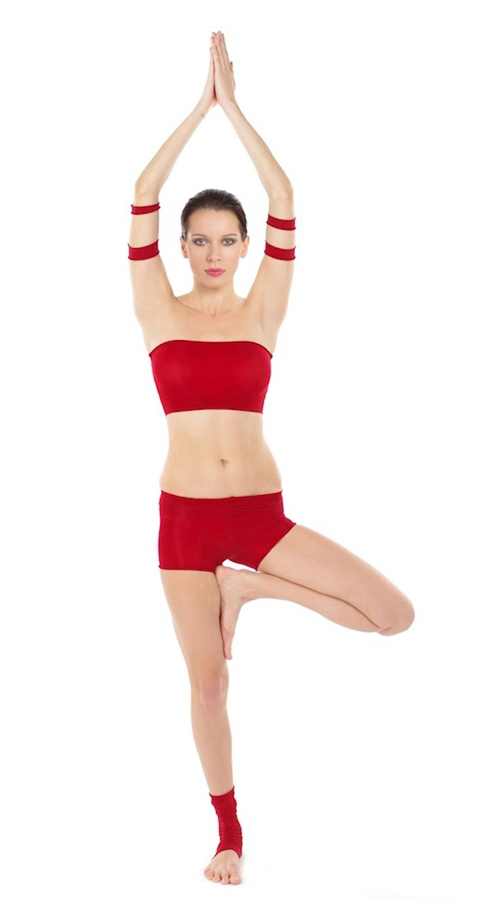

In [ ]:
img

The actual image is of Vrikshasana

In [ ]:
def predict(img):
    img = transformations(img)
    outputs = model(k.to("cuda"))
    _, predicted = torch.max(outputs.data,1)
    return dataset.classes[predicted]

print("The predicted yogasana : ",predict(img))

The predicted yogasana :  vriksasana
